<a href="https://colab.research.google.com/github/DanielhCarranza/Machine-Learning-in-Health/blob/master/Diabetic_Retinpathy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection


Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

![dfdf](https://storage.googleapis.com/kaggle-competitions/kaggle/4104/media/retina.jpg)

*Fig. 1 retina*

The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.

Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.

Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.

The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this competition is to push an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential. The winning models will be open sourced to maximize the impact such a model can have on improving DR detection.

* [Dataset](https://www.kaggle.com/c/diabetic-retinopathy-detection/data)
* [Bayesian Evaluation for Diagnosis of DR](https://github.com/OATML/bdl-benchmarks/blob/alpha/notebooks/diabetic_retinopathy_diagnosis.ipynb)


### Setup

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle competitions download -c diabetic-retinopathy-detection

In [ ]:
! mkdir Diabetic_Retinopathy 

cd Diabetic_Retinopathy

! 7za x train.zip.001 

! unzip trainLabels.csv.zip

In [ ]:
seg= "s3://ieee-dataport/open/3754/A.%20Segmentation.zip"
grading= "s3://ieee-dataport/open/3754/B.%20Disease%20Grading.zip"
localization = "s3://ieee-dataport/open/3754/C.%20Localization.zip"

## EDA

In [ ]:
ls train/models

res50_512_classification-985acc.pth


In [ ]:
import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.vision.interpret import SegmentationInterpretation

from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, precision_recall_curve


In [ ]:
len(os.listdir('train'))

35127

In [ ]:
path= Path('train')
path.ls()[0:5]

[PosixPath('train/32924_left.jpeg'),
 PosixPath('train/5835_right.jpeg'),
 PosixPath('train/2566_right.jpeg'),
 PosixPath('train/19475_right.jpeg'),
 PosixPath('train/2952_left.jpeg')]

In [ ]:
df = pd.read_csv('trainLabels.csv')
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
sns.countplot
df.level.value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64


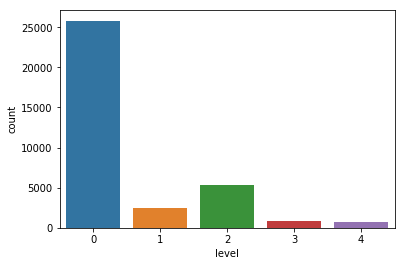

In [ ]:
sns.countplot(x='level', data=df)
print(df.level.value_counts())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
image    35126 non-null object
level    35126 non-null int64
dtypes: int64(1), object(1)
memory usage: 548.9+ KB


In [ ]:
get_lb = lambda df,item: df[df.image==item.name[:-5]].values[0][-1]
get_labels=partial(get_lb, df)
# get_labels(src.items[0]) 

In [ ]:
src = (ImageList.from_folder(path)
       .split_by_rand_pct()
       .label_from_func(get_labels))
src

LabelLists;

Train: LabelList (28101 items)
x: ImageList
Image (3, 2592, 3888),Image (3, 2592, 3888),Image (3, 2592, 3888),Image (3, 1920, 2560),Image (3, 2336, 3504)
y: CategoryList
0,2,0,0,0
Path: train;

Valid: LabelList (7025 items)
x: ImageList
Image (3, 2592, 3888),Image (3, 2848, 4272),Image (3, 2592, 3888),Image (3, 2304, 3456),Image (3, 1920, 2560)
y: CategoryList
2,0,0,0,2
Path: train;

Test: None

In [ ]:
def get_data(bs, sz, **kwargs):
  return (src.transform(get_transforms(flip_vert=True), size=sz)
          .databunch(bs=bs, num_workers=4)
          .normalize())


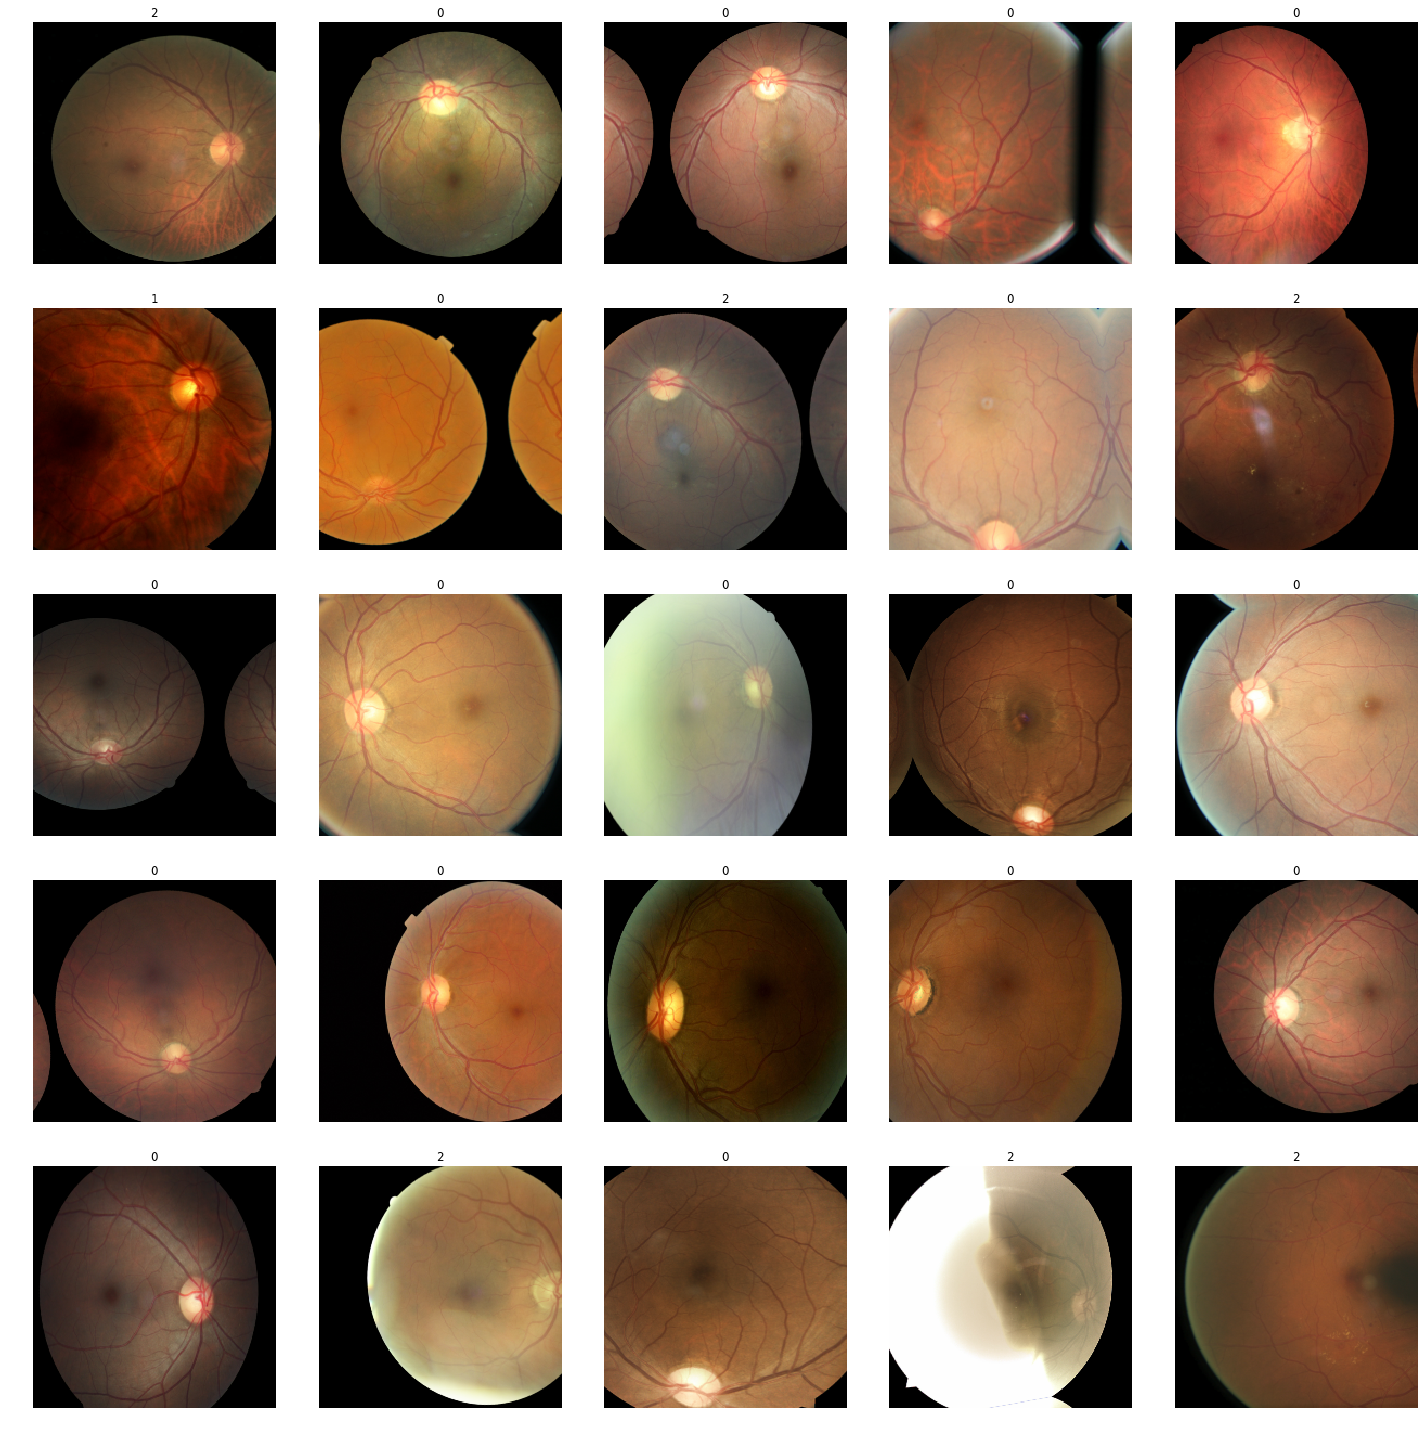

In [ ]:
data = get_data(64, 224)
data.show_batch()

In [ ]:
data512 = get_data(16, 512)

In [ ]:
model = torch.load('train/models/res50_512_classification-985acc.pth')
model.keys()

dict_keys(['model', 'opt'])

In [ ]:
model['model']

In [ ]:
resnet50 = models.resnet50(pretrained=False)
model = torch.nn.Sequential(*list(resnet50.children())[:-2])

import torch.nn as nn

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        sz = 1
        self.ap,self.mp = nn.AdaptiveAvgPool2d(sz), nn.AdaptiveMaxPool2d(sz)
        def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Lambda(nn.Module):
    "An easy way to create a pytorch layer for a simple `func`."
    def __init__(self, func):
        "create a layer that simply calls `func` with `x`"
        super().__init__()
        self.func=func

    def forward(self, x): return self.func(x)

model1 = nn.Sequential(AdaptiveConcatPool2d(),
                       Lambda(lambda x: x.view(x.size(0),-1)),
                       nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                       nn.Dropout(p=0.25),
                       nn.Linear(in_features=1024, out_features=512, bias=True),
                       nn.ReLU(inplace=True),
                       nn.BatchNorm1d(512, eps=1e-05,momentum=0.1, affine=True, track_running_stats=True),
                       nn.Dropout(0.5),
                       nn.Linear(in_features=512, out_features=102, bias=True))

model2  = nn.Sequential(model, model1)
for param in model2.parameters():
            param.requires_grad = False


state_dict = torch.load('train/models/res50_512_classification-985acc.pth', map_location='cpu')

model2.load_state_dict(state_dict['model'], strict=False)

## Training 

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='res50_224'),
        ShowGraph]

In [ ]:
learner = cnn_learner(data, models.resnet50, metrics= [accuracy], callback_fns=cbfs)

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.790996,0.772813,0.754591,2:24:48


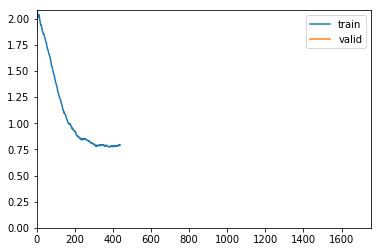

In [ ]:
lr= 1e-1
learner.fit_one_cycle(4, slice(1e-3,1e-2, lr))

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr= 1e-4
learner.fit_one_cycle(20, slice(1e-5,3*lr)) 

## Evaluation

In [ ]:
conf= ClassificationInterpretation.from_learner(learner)
conf.plot_confusion_matrix(figsize=(10,8))

In [ ]:
# Predictions of the validation data
preds, y_true=learner.get_preds()
y_true.shape, preds.shape

In [ ]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_true, preds, target_names=classes)
print(report)